# Propagation into experimental variograms

This notebook uses the `pancake` dataset of `scikit-gstat` to propagate observation uncertainties into the experimental variogram. The propagation is done in two steps. First, the inherit error imposed to observations due to image resolution is propagated. This is based on the fact that the original image was saved as PNG, which is represented as unsigned 8-bit integers, which have thus a value range of 256. The first uncertainty propagation represents the 1bit-resolution limit with 50000 different, randomly picked 64bit floats. This is comparable to errors imposed due to digital sensor devices, which all have a resolution (of usual 8 or 10bit for most ADC) or due to data storage, where floating point numbers need to be approximated by a given resolution.
The secod step propagates simulated measurement uncertainties due to sensor device precision. This is done by $\frac{2}{256}$, $\frac{5}{256}$, $\frac{10}{256}$, $\frac{15}{256}$ and $\frac{25}{256}$ of the observation space.


In [1]:
import skgstat as skg
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import warnings

warnings.filterwarnings('ignore')
plt.style.use('./paper.mplstyle')

## 1.1 Data sample

Load the pancake dataset from `scikit-gstat` using exactly the same seed as in the benchmark. Then, the saved error bounds from the benchmark are still valid.

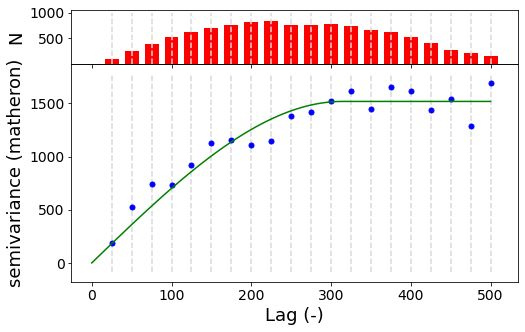

In [73]:
# get the data
coordinates, values = skg.data.pancake(N=150, seed=42).get('sample')

# estimate the variogram
vario = skg.Variogram(coordinates, values, n_lags=20)
vario.maxlag = 500

# plot
fig = vario.plot()

Load the error bounds from the benchmark test:

In [3]:
bounds = np.load('./data/observation_uncertainty.npy').T

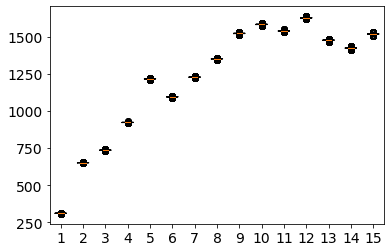

In [4]:
d = plt.boxplot(bounds, notch=True)

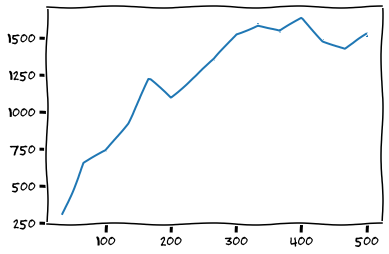

In [5]:
yerr = np.column_stack((
    np.mean(bounds, axis=0) - np.min(bounds, axis=0),
    np.max(bounds, axis=0) - np.mean(bounds, axis=0)
)).T

with plt.xkcd():
    plt.errorbar(vario.bins, np.mean(bounds, axis=0), yerr=yerr)


## 1.2 Propagate to parameters

In [129]:
N = 50000         # iterations
SIGMA = 0         # observation-uncertainty
RERUN = True      # Re-run or load MC sim

# calculate the distance matrix only once
ms = skg.MetricSpace(coordinates)

# prepare input data
input_data = np.array([values,] * N)

# in the special case of uint8 values we just turn the values into floats of
# within the range of one R-band value
# i.e.: v = 127 -> [126.5:127.5[
np.random.seed(42)
input_data = input_data.astype(float) + (np.random.random(size=input_data.shape) - 0.5) * (1 + SIGMA)

# result container
ebins = np.zeros((vario.n_lags, N))
eparams = np.zeros((3, N))
emodels = np.zeros((100, N))

# lags for model evaluation
x = np.linspace(0, vario.bins[-1], 100)

# Monte-Carlo run
if RERUN:
    for i, vals in tqdm(enumerate(input_data), total=N):
        v = skg.Variogram(ms, vals, n_lags=vario.n_lags, maxlag=500)
        ebins[:, i] = v.experimental
        eparams[:, i] = v.parameters
        emodels[:, i] = v.fitted_model(x)

    # save results
    with open(f'./data/MC_results_{N}_{SIGMA}.pickle', 'wb') as f:
        pickle.dump(dict(ebins=ebins, eparams=eparams, emodels=emodels), f)
else:
    with open(f'./data/MC_results_{N}_{SIGMA}.pickle', 'rb') as f:
        _d = pickle.load(f)
        ebins = _d['ebins']
        eparams = _d['eparams']
        emodels = _d['emodels']
        
# print results
print('Lags:\n----------')
print((np.max(ebins, axis=1) - np.min(ebins, axis=1)).round(1))
print('Parameters:\n---------')
print(np.max(eparams, axis=1) - np.min(eparams, axis=1).round(3))

100%|██████████| 50000/50000 [05:01<00:00, 166.05it/s]

Lags:
----------
[ 8.1 10.2 11.5 11.5 13.4 15.1 13.9 13.5 14.8 16.9 16.9 18.1 19.1 18.8
 21.2 21.3 20.8 25.1 23.1 31.6]
Parameters:
---------
[ 6.08178392 18.36191369  0.        ]


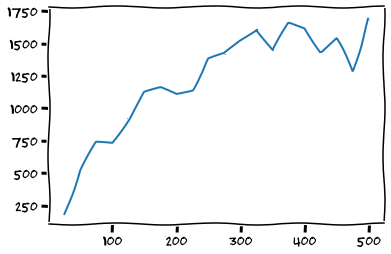

In [130]:
# plot
yerr = np.column_stack((
    np.mean(ebins, axis=1) - np.min(ebins, axis=1),
    np.max(ebins, axis=1) - np.mean(ebins, axis=1)
)).T

with plt.xkcd():
    plt.errorbar(vario.bins, np.mean(ebins, axis=1), yerr=yerr)

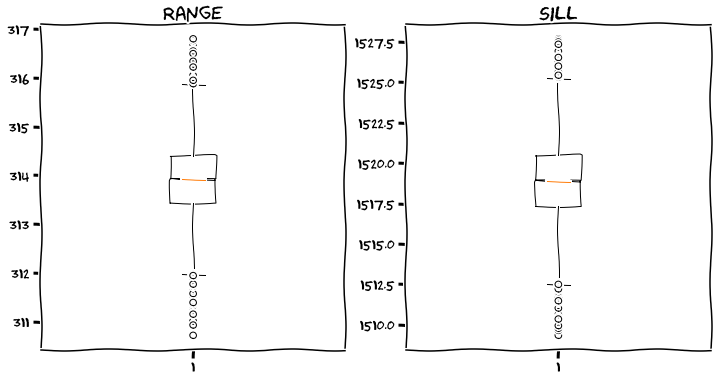

In [131]:
with plt.xkcd():
    fig, axes = plt.subplots(1,2, figsize=(12, 6))
    axes[0].boxplot(eparams[0, :], notch=True)
    axes[0].set_title('Range')
    axes[1].boxplot(eparams[1, :], notch=True)
    axes[1].set_title('Sill')

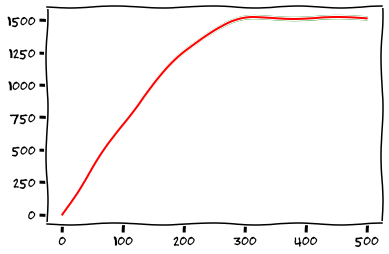

In [132]:
with plt.xkcd():
    plt.plot(x, np.min(emodels, axis=1), '-g')
    plt.plot(x, np.max(emodels, axis=1), '-g')
    plt.plot(x, np.mean(emodels, axis=1), '-r', lw=2)

## 1.3 Kiging observation uncertainty 

In [133]:
# load
v1 = skg.Variogram(ms, values, n_lags=15, maxlag=500, fit_method='manual', 
                   fit_range=np.min(eparams[0]), fit_sill=np.min(eparams[1]))
v2 = skg.Variogram(ms, values, n_lags=15, maxlag=500, fit_method='manual',
                   fit_range=np.max(eparams[0]), fit_sill=np.max(eparams[1]))

In [134]:
xx = yy = range(500)

krige1 = v1.to_gs_krige()
krige2 = v2.to_gs_krige()

field1, _ = krige1.structured((xx, yy))
field2, _ = krige2.structured((xx, yy))

with open(f'./data/exp_interp_fields_{N}_{SIGMA}.pickle', 'wb') as f:
    pickle.dump([field1, field2], f)

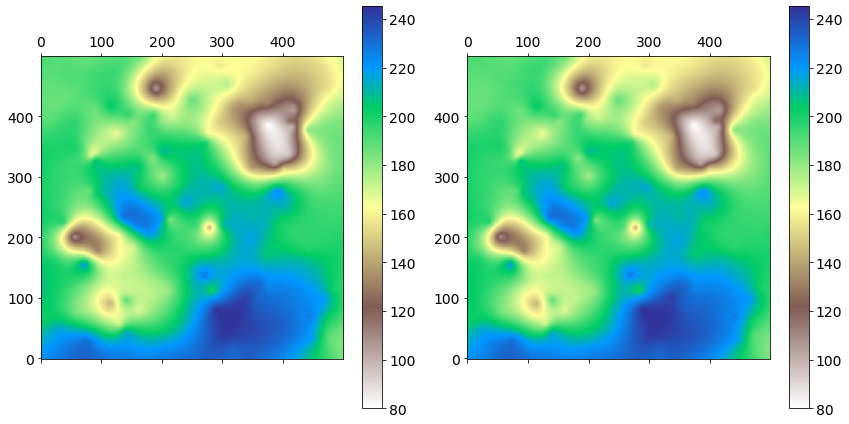

In [135]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

# get the value bounds
vmin = np.min((field1, field2))
vmax = np.max((field1, field2))

_im1 = ax[0].matshow(field1.T, origin='lower', cmap='terrain_r', vmin=vmin, vmax=vmax)
_im2 = ax[1].matshow(field2.T, origin='lower', cmap='terrain_r', vmin=vmin, vmax=vmax)
plt.colorbar(_im1, ax=ax[0])
plt.colorbar(_im2, ax=ax[1])
plt.tight_layout()

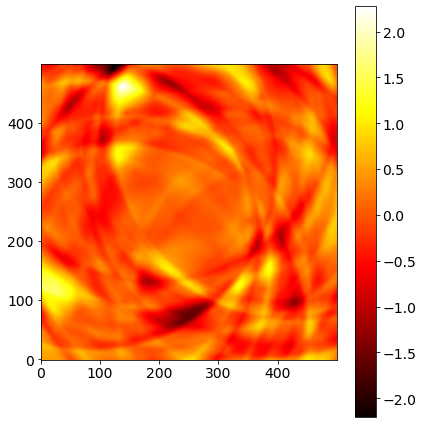

In [136]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
kerr = field1.T - field2.T
im = ax.imshow(kerr, origin='lower', cmap='hot')
plt.colorbar(im)
plt.tight_layout()

## 1.3 Output

In [138]:
obs_error = SIGMA / 256 * 100
rel_error = (np.max(kerr) - np.min(kerr)) / 256 * 100

print('Uncertainty propagation\n-----------------------\n')
print('Observation uncertainty:   %.1f%%' % obs_error)
print('Prop. Kriging uncertainty: %.1f%%' % rel_error)

Uncertainty propagation
-----------------------

Observation uncertainty:   0.0%
Prop. Kriging uncertainty: 1.7%
